In [1]:
from doctr.models import ocr_predictor, detection_predictor
from doctr.models.detection.predictor import DetectionPredictor
from doctr.models.builder import DocumentBuilder
from doctr.utils.geometry import extract_crops
from doctr.io import DocumentFile
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from doctr.io.image import read_img_as_tensor
import numpy as np
from PIL import Image
from transformers import pipeline, Pipeline
from glob import glob

/Users/markjos/projects/montague_archiving/.ocr_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
typed_fp = '/Users/markjos/projects/montague_archiving/data/OCR-materials/Printed or Typed/1961-12-18_From-Tarski_Ownership-of-ideas/61-12-18_From-Tarski_Ownership-of-ideas_b20-f12-IMG_0808_2.jpg'
hand_fp = '/Users/markjos/projects/montague_archiving/data/OCR-materials/Handwritten/63-3-4_From-Feferman_A_new-house_b21-f2-IMG_1115.jpg'
crop_fp = '/Users/markjos/projects/montague_archiving/crops-new/cropped_box_6.jpg'

In [13]:
typed_tensor = read_img_as_tensor(typed_fp).unsqueeze(0)
hand_tensor = read_img_as_tensor(hand_fp).unsqueeze(0)

In [14]:
typed_doc = DocumentFile.from_images(typed_fp)
hand_doc = DocumentFile.from_images(hand_fp)
crop_doc = DocumentFile.from_images(crop_fp)

In [15]:
pipe = pipeline("image-to-text", model="microsoft/trocr-base-handwritten")
img=Image.fromarray(crop_doc[0])
result = pipe(img)
result

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'generated_text': 'Dean Richard'}]

In [49]:
typed_doc[0].shape, typed_tensor.shape

((2816, 2112, 3), torch.Size([1, 3, 2112, 2816]))

In [108]:
hand_doc[0].shape, hand_tensor.shape

((2816, 2112, 3), torch.Size([1, 3, 2816, 2112]))

In [119]:
# taken from: https://github.com/mindee/notebooks/blob/main/doctr/artefact_detection.ipynb
# Plots the predictions on the input image
def plot_predictions(image, boxes):
    image = (255 * image.squeeze(0).permute(2, 1, 0).numpy().copy()).round().astype(np.uint8)
    for box in boxes:
        # Bounding box around artefacts
        cv2.rectangle(image, (box[1], box[0]), (box[3], box[2]), (255, 255, 255), 2)
        # Filled rectangle above bounding box
    figure(figsize=(10, 8), dpi=90)
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [27]:
detector = detection_predictor(pretrained=True)

In [121]:
result = detector(hand_doc)
result

[{'words': array([[0.52148438, 0.90917969, 0.60644531, 0.95019531, 0.73062563],
         [0.35644531, 0.90722656, 0.515625  , 0.95117188, 0.73435616],
         [0.65917969, 0.87597656, 0.8125    , 0.95117188, 0.75083715],
         [0.35644531, 0.87402344, 0.42675781, 0.90527344, 0.76487958],
         [0.44921875, 0.87011719, 0.58203125, 0.91503906, 0.66444516],
         [0.19921875, 0.87304688, 0.33300781, 0.90332031, 0.82702106],
         [0.11425781, 0.87304688, 0.18261719, 0.90625   , 0.89373958],
         [0.59472656, 0.87011719, 0.65625   , 0.90234375, 0.68098134],
         [0.41503906, 0.83496094, 0.53320312, 0.86132812, 0.67018306],
         [0.33007812, 0.82910156, 0.38769531, 0.859375  , 0.73963046],
         [0.18945312, 0.82324219, 0.28222656, 0.86914062, 0.83350861],
         [0.11035156, 0.81933594, 0.1796875 , 0.85644531, 0.86804581],
         [0.453125  , 0.7890625 , 0.5078125 , 0.81835938, 0.83718294],
         [0.38085938, 0.73925781, 0.48730469, 0.796875  , 0.8270787 

In [127]:
# Load the image using PIL
img_pil = Image.open(hand_fp)

# Get the dimensions of the image
img_width, img_height = img_pil.size


# Alias boxes
boxes = result[0]['words']
coords = boxes.copy()

# Iterate through each bounding box
for i, box in enumerate(boxes):
    x_min, y_min, x_max, y_max, _ = box  # Unpack the box coordinates
    # y_min, x_min, y_max, x_max, _ = box  # Unpack the box coordinates
    # y_min, y_max = 1-y_max, 1-y_min

    # Convert normalized coordinates to pixel values
    left = x_min * img_width
    top = y_min * img_height
    right = x_max * img_width
    bottom = y_max * img_height

    coords[i][0] = left
    coords[i][1] = top
    coords[i][2] = right
    coords[i][3] = bottom

    # Crop the image to the bounding box
    cropped_img = img_pil.crop((left, top, right, bottom))

    # Save the cropped image
    output_path = f"crops/cropped_box_{i+1}.jpg"
    cropped_img.save(output_path)

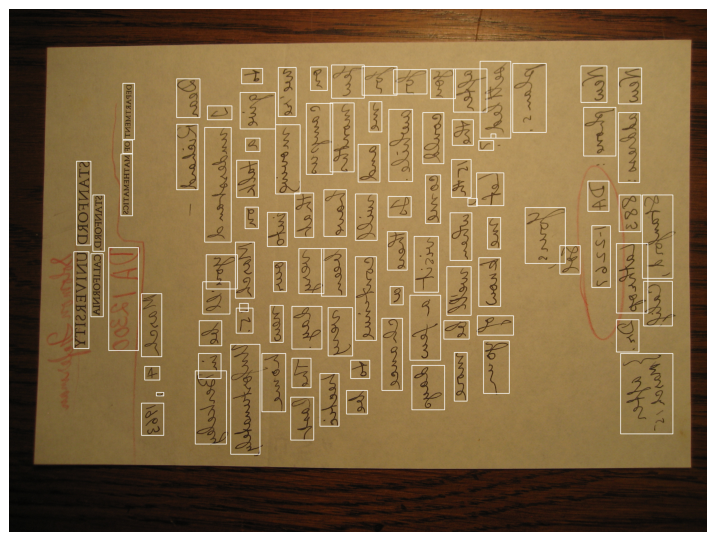

In [124]:
plot_predictions(hand_tensor, coords.round().astype(int))

In [125]:
Image.open(hand_fp).show()

In [133]:
pipe = pipeline("image-to-text", model="microsoft/trocr-base-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/markjos/projects/montague_archiving/.ocr_venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [147]:
ocr = ocr_predictor(pretrained=True, export_as_straight_boxes=True)
ocr_result = ocr(typed_doc)

In [150]:
type(ocr)

doctr.models.predictor.pytorch.OCRPredictor

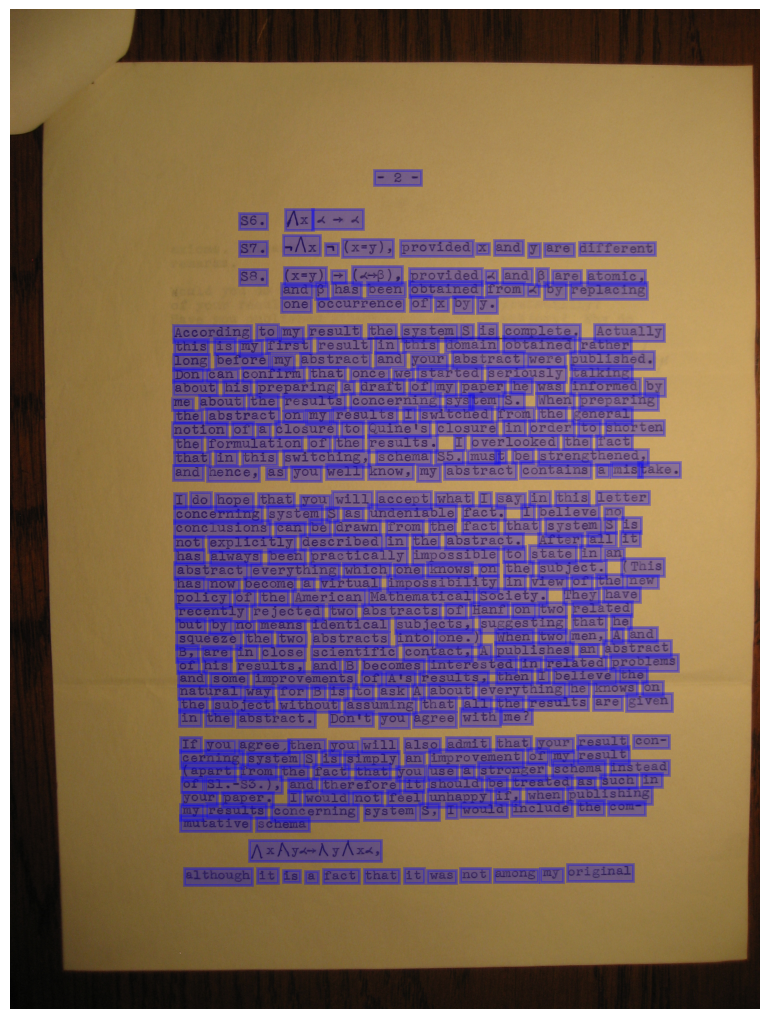

In [149]:
ocr_result.show()

In [161]:
lines = DocumentBuilder()._resolve_lines(boxes)

In [247]:
hand_doc[0].shape

(2816, 2112, 3)

In [248]:
line_crops = extract_crops(hand_doc[0], line_boxes)

In [249]:
line_crops[0].shape

(69, 755, 3)

In [168]:
line_coords = np.zeros([len(lines), 4])
for i, line in enumerate(lines):
    line_boxes = [coords[j] for j in line]
    
    line_xmins = [box[0] for box in line_boxes]
    line_xmin = min(line_xmins)
    line_coords[i][0]=line_xmin

    line_ymins = [box[1] for box in line_boxes]
    line_ymin = min(line_ymins)   
    line_coords[i][1]=line_ymin

    line_xmaxs = [box[2] for box in line_boxes]
    line_xmax = max(line_xmaxs)
    line_coords[i][2]=line_xmax

    line_ymaxs = [box[3] for box in line_boxes]
    line_ymax = max(line_ymaxs)
    line_coords[i][3]=line_ymax
line_coords

array([[ 616.6875,  261.25  , 1371.5625,  330.    ],
       [ 752.8125,  330.    , 1243.6875,  385.    ],
       [ 303.1875,  451.    ,  837.375 ,  506.    ],
       [ 965.25  ,  401.5   , 1379.8125,  522.5   ],
       [1150.875 ,  533.5   , 1722.1875,  624.25  ],
       [ 284.625 ,  676.5   ,  732.1875,  770.    ],
       [ 393.9375,  750.75  , 1757.25  ,  921.25  ],
       [ 243.375 ,  893.75  , 1798.5   , 1075.25  ],
       [ 239.25  , 1075.25  ,  748.6875, 1174.25  ],
       [ 822.9375, 1020.25  , 1627.3125, 1122.    ],
       [ 744.5625, 1152.25  ,  924.    , 1229.25  ],
       [1202.4375, 1135.75  , 1740.75  , 1262.25  ],
       [ 237.1875, 1199.    ,  670.3125, 1306.25  ],
       [ 969.375 , 1168.75  , 1150.875 , 1270.5   ],
       [ 381.5625, 1254.    , 1685.0625, 1391.5   ],
       [ 228.9375, 1300.75  ,  363.    , 1432.75  ],
       [1419.    , 1361.25  , 1635.5625, 1454.75  ],
       [ 235.125 , 1397.    , 1338.5625, 1564.75  ],
       [ 408.375 , 1504.25  , 1540.6875, 1628.

In [235]:
line_boxes = np.zeros([len(lines), 4])
for i, line in enumerate(lines):
    these_boxes = [boxes[j] for j in line]
    
    line_xmins = [box[0] for box in these_boxes]
    line_xmin = min(line_xmins)
    line_boxes[i][0]=line_xmin

    line_ymins = [box[1] for box in these_boxes]
    line_ymin = min(line_ymins)   
    line_boxes[i][1]=line_ymin

    line_xmaxs = [box[2] for box in these_boxes]
    line_xmax = max(line_xmaxs)
    line_boxes[i][2]=line_xmax

    line_ymaxs = [box[3] for box in these_boxes]
    line_ymax = max(line_ymaxs)
    line_boxes[i][3]=line_ymax
line_boxes

array([[0.29199219, 0.09277344, 0.64941406, 0.1171875 ],
       [0.35644531, 0.1171875 , 0.58886719, 0.13671875],
       [0.14355469, 0.16015625, 0.39648438, 0.1796875 ],
       [0.45703125, 0.14257812, 0.65332031, 0.18554688],
       [0.54492188, 0.18945312, 0.81542969, 0.22167969],
       [0.13476562, 0.24023438, 0.34667969, 0.2734375 ],
       [0.18652344, 0.26660156, 0.83203125, 0.32714844],
       [0.11523438, 0.31738281, 0.8515625 , 0.38183594],
       [0.11328125, 0.38183594, 0.35449219, 0.41699219],
       [0.38964844, 0.36230469, 0.77050781, 0.3984375 ],
       [0.35253906, 0.40917969, 0.4375    , 0.43652344],
       [0.56933594, 0.40332031, 0.82421875, 0.44824219],
       [0.11230469, 0.42578125, 0.31738281, 0.46386719],
       [0.45898438, 0.41503906, 0.54492188, 0.45117188],
       [0.18066406, 0.4453125 , 0.79785156, 0.49414062],
       [0.10839844, 0.46191406, 0.171875  , 0.50878906],
       [0.671875  , 0.48339844, 0.77441406, 0.51660156],
       [0.11132812, 0.49609375,

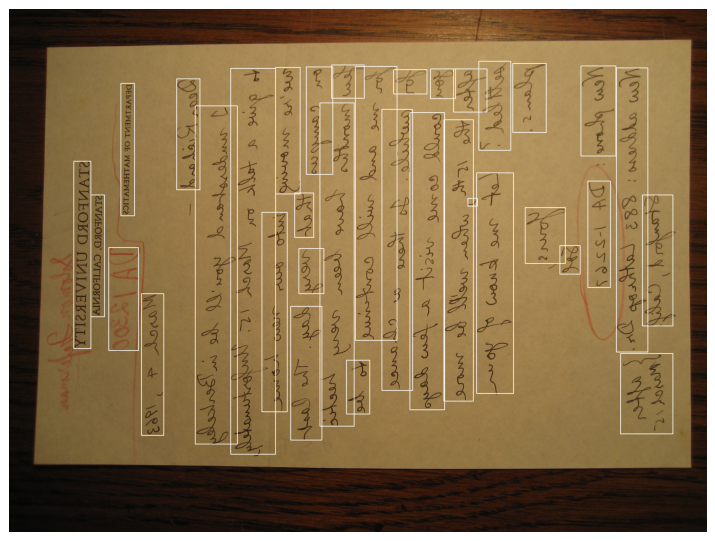

In [169]:
plot_predictions(hand_tensor, line_coords.round().astype(int))

In [171]:
# Load the image using PIL
img_pil = Image.open(hand_fp)

# Get the dimensions of the image
img_width, img_height = img_pil.size


# Alias boxes
boxes = result[0]['words']
coords = boxes.copy()

# Iterate through each bounding box
for i, box in enumerate(line_coords):
    left, top, right, bottom = box  # Unpack the box coordinates


    # Crop the image to the bounding box
    cropped_img = img_pil.crop((left, top, right, bottom))

    # Save the cropped image
    output_path = f"crops/cropped_box_{i+1}.jpg"
    cropped_img.save(output_path)

In [246]:
line_crops[0].shape

(2816, 52, 1)

In [245]:
img=Image.open(typed_fp)
np.asarray(img).shape

(2816, 2112, 3)

In [250]:
for i, box in enumerate(line_crops):
    crop = Image.fromarray(box)
    output_path = f"crops-new/cropped_box_{i+1}.jpg"
    crop.save(output_path)

In [ ]:
for file in sorted(glob('crops/*.jpg')):
    image = read_img_as_tensor(file)
    image = (255 * image.squeeze(0).permute(1, 2, 0).numpy().copy()).round().astype(np.uint8)
    plt.imshow(image)
    plt.show()
    print(pipe(file))

In [9]:
ocr_pipe = pipeline("image-to-text", model="microsoft/trocr-large-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
text_detector = detection_predictor(pretrained=True)

In [15]:

# let's encapsulate!
def get_line_boxes(boxes, lines):
    line_boxes = np.zeros([len(lines), 4])
    for i, line in enumerate(lines):
        these_boxes = [boxes[j] for j in line]
        
        line_xmins = [box[0] for box in these_boxes]
        line_xmin = min(line_xmins)
        line_boxes[i][0]=line_xmin

        line_ymins = [box[1] for box in these_boxes]
        line_ymin = min(line_ymins)   
        line_boxes[i][1]=line_ymin

        line_xmaxs = [box[2] for box in these_boxes]
        line_xmax = max(line_xmaxs)
        line_boxes[i][2]=line_xmax

        line_ymaxs = [box[3] for box in these_boxes]
        line_ymax = max(line_ymaxs)
        line_boxes[i][3]=line_ymax
    return line_boxes

def perform_ocr(img_fp: str, text_detector: DetectionPredictor, ocr_pipe: Pipeline ) -> str:
    img_doc = DocumentFile.from_images(img_fp)
    out_txt = ''

    text_preds = text_detector(img_doc)
    for i, page_text in enumerate(text_preds):
        page = img_doc[i]
        out_txt+=f'PAGE {i+1}\n\n'
        word_boxes = page_text['words']
        line_groups = DocumentBuilder()._resolve_lines(word_boxes)
        line_boxes = get_line_boxes(word_boxes, line_groups)
        crops = extract_crops(page, line_boxes)
        crop_imgs = [Image.fromarray(crop) for crop in crops]
        result = ocr_pipe(crop_imgs)
        for line in result:
            line_txt = ' '.join(chunk['generated_text'] for chunk in line)
            out_txt+=line_txt+'\n'
    return out_txt

result = perform_ocr(hand_fp, text_detector, ocr_pipe)
result

/Users/markjos/projects/montague_archiving/.ocr_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


"PAGE 1\n\nStanford University\nStanford, California\nDepartment of Mathematics.\nDA ( 2300\nMarch 4, 1963\nDean Ruehand\nI understand you'll be in Berkeley\nto give a talk on March 15. Unfortunately\nwe're moving\ninto our new home\nthat\nday. The last\non campus.\nvery.\nmonths have been very hostile\nfew.\nto be\nfor me and will continue\nawhide. Is there a chance\nfor\ncould come visit a few days\nyou\nthe 15th, when well be more\nafter\nj\nsettled?\nLet me know of your\nplans.\nyoung.\nsol.\nNew phone\nDA 1-2267\nNew address : 883 Lathrop Dr.\nStanford, Calif.\nsmasters.\n"

In [27]:
print(result)

PAGE 1

Stanford University
Stanford California
department of mathematics
dazzoo
March 4, 1963
Dean Richard
I understand you'll be in Berkeley
to give a talk on March 15. Unfortunately
me're moving into over good damage
thalr.
The last
on campus.
day.
heetic
months have
heart.
very
fews.
and will continue to be
for me.
( In awhile. to those, an alliance
could come visit a few days
your
after the 15th, when well be more
settled?
Let me know of you
plans.
young,
sol
New phone IDA 12267
New address : 883 Lathyop Dr.
" Emalastic
Stamford, Calif.



In [2]:
pipe = pipeline("text-generation", model="PleIAs/OCRonos", max_new_tokens=1024)

Loading checkpoint shards: 100%|██████████| 4/4 [01:03<00:00, 15.96s/it]


In [4]:
result = """
Stanford University
Stanford California
department of mathematics
dazzoo
March 4, 1963
Dean Richard
I understand you'll be in Berkeley
to give a talk on March 15. Unfortunately
me're moving into over good damage
thalr.
The last
on campus.
day.
heetic
months have
heart.
very
fews.
and will continue to be
for me.
( In awhile. to those, an alliance
could come visit a few days
your
...
New address : 883 Lathyop Dr.
" Emalastic
Stamford, Calif.
"""

In [6]:
prompt = "### Text ###\n" + result + "\n\n### Correction ###\n"
messages = [
    {"role": "user", "content": prompt},
]
pipe(messages)

KeyboardInterrupt: 